In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu, kruskal

%matplotlib inline

Исходные данные я немного преобразовала для того, чтобы они занимали меньше памяти. И общую табличку разбила на контроль и тест, и сохранила их отдельно. Весь код, проделывающий это, закомментирован.

In [2]:
# data = pd.read_table('log.txt', header=None, names=['slot', 'userID', 'ts', 'browser', 'all_cl'])

# for row in data.iterrows():
#     row = row[1]
#     for cl in data.columns:
#         row[cl] = row[cl][len(cl)+1:]

# data['all_cl'] = data['all_cl'].astype(int)

In [3]:
# control = data[data['slot'] == 'control']
# exp = data[data['slot'] == 'exp']

# control = control.drop('slot', axis=1)
# exp = exp.drop('slot', axis=1)

# control.to_csv('control.csv')
# exp.to_csv('exp.csv')

In [4]:
control = pd.read_csv('control.csv', index_col=0)
exp = pd.read_csv('exp.csv', index_col=0)

/usr/local/Cellar/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
control.head()

,userID,ts,browser,all_cl
17,6,2016-03-03,Browser #4,3
27,8,2016-03-03,Browser #4,1
31,10,2016-03-03,Browser #4,0
32,10,2016-03-03,Browser #4,2
35,15,2016-03-03,Browser #14,1


In [6]:
exp.head()

,userID,ts,browser,all_cl
0,1,2016-03-03,Browser #2,1
1,1,2016-03-03,Browser #2,5
2,1,2016-03-03,Browser #2,1
3,1,2016-03-03,Browser #2,1
4,1,2016-03-03,Browser #2,6


В следующей ячейке приведен код, который по датафрэйму считает необходимую метрику (сумму кликов) для каждого пользователя.

In [7]:
def clicks_sum_metric(data):
    return data.groupby(by='userID').sum()

In [8]:
control_values = clicks_sum_metric(control)
exp_values = clicks_sum_metric(exp)

In [9]:
def print_stats(data1, data2):
    print('number of samples: {}, {}'.format(len(data1), len(data2)))
    print('mean values: {}, {}'.format(data1.mean().values[0], data2.mean().values[0]))
    print('variances: {}, {}'.format(data1.var().values[0], data2.var().values[0]))

Нам хочется проверить, совпадают ли математические ожидания распределений контрольных значений и тестовых. При этом у нас есть значения случайных величин сэмплированных из каждой выборки. Давайте для начала на эти выборки посмотрим хотя бы для того, чтобы убедиться, что они примерно равны по основным параметрам (числу элементов в выборке, среднему и дисперсии). И посмотрим на графики имперических распределений, чтобы убедиться, что эти распределения не похожи на нормальные, то есть что мы не сможем использовать `ttest` для проверки.

In [10]:
print_stats(control_values, exp_values)

number of samples: 284392, 281450
mean values: 11.287332273762974, 11.589351572215314
variances: 411.6638348007596, 409.06767296029335


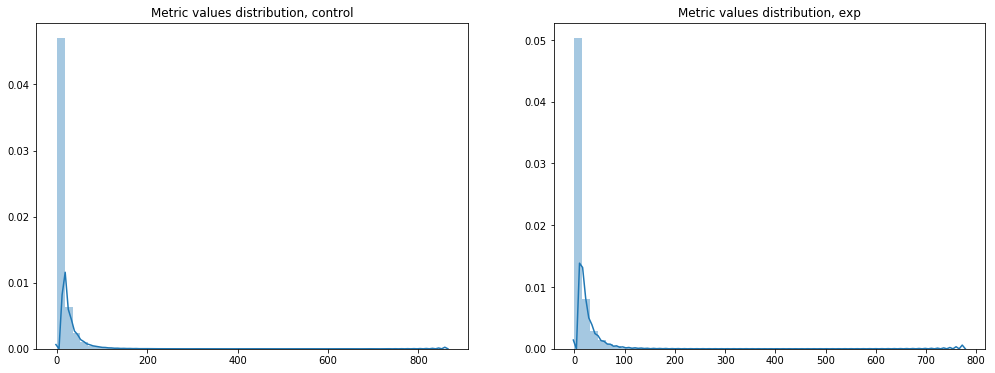

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(17, 6))

sns.distplot(control_values, ax=axs[0])
axs[0].set_title('Metric values distribution, control')
sns.distplot(exp_values, ax=axs[1])
axs[1].set_title('Metric values distribution, exp')

plt.show()

In [12]:
mannwhitneyu(control_values, exp_values)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Посмотрели на уровень значимости и приходим к выводу, что тестируемая система отличается от контроля при использовании рассматриваемой метрики.

Теперь хочется ответить на вопрос, локализуется ли изменение кликов в каком-либо срезе?

Для ответа на вопрос, какие вообще можно сделать срезы, давайте вспомним, какие есть данные. Итак, у нас есть:
* пользователи (по которым мы группируем данные для метрики), они отнесены либо к эксперименту, либо к контролю
* даты запросов (одна неделя, так что мы вполне удовлетворяем требованию, что и будние дни, и выходные рассмотрены)
* количество кликов на запрос (данные, которые мы группируем для рассчета метрики)
* и id браузера

Таким образом, видно, что вариантов для среза немного -- их можно делать только по браузерам. Займемся этим, попутно не забывая проверять, что в срезах все еще учтены все дни недели как для контрольной группы, так и для тестовой.

In [13]:
for browser in control['browser'].unique():
    print(browser)
    control_slice = control[control['browser'] == browser]
    exp_slice = exp[exp['browser'] == browser]
    assert set(control_slice['ts'].unique()) == set(exp_slice['ts'].unique()), browser
    control_slice = clicks_sum_metric(control_slice)
    exp_slice = clicks_sum_metric(exp_slice)
    pvalue = mannwhitneyu(control_slice, exp_slice)[1]
    print_stats(control_slice, exp_slice)
    print('test result (p-value): {}'.format(pvalue))
    print()

Browser #4
number of samples: 78681, 78152
mean values: 13.527980071427663, 13.550452963455829
variances: 439.70244854936885, 451.0112098884393
test result (p-value): 0.40760617658454984

Browser #14
number of samples: 44903, 44220
mean values: 4.615036857225575, 6.661148801447309
variances: 117.36518478286816, 152.26542105527844
test result (p-value): 0.0

Browser #2
number of samples: 55793, 54944
mean values: 10.143996558708082, 10.194179528246943
variances: 356.9563222624373, 365.86788669372015
test result (p-value): 0.0272438604197241

Browser #20
number of samples: 16998, 16931
mean values: 13.289622308506884, 13.18362766522946
variances: 441.0719061820192, 467.55239820372697
test result (p-value): 0.45366656388735377

Browser #22
number of samples: 71825, 71080
mean values: 12.249356073790462, 12.080275745638717
variances: 454.9641628522271, 421.781847614523
test result (p-value): 0.2574055152210032

Browser #17
number of samples: 16354, 16253
mean values: 16.30989360401125, 16.

Видно, что `p-value` на всех браузерах, кроме `#14`, не опускается ниже 0.01 (можно, конечно, рассматривать уровень значимости равный 0.05, тогда это будут еще и браузеры `#2` и `#17`, но если смотреть на отличия дисперсии и матожидания в сравниваемых выборках, в глаза бросается только `#14`). Но ответ на вопрос о локализации изменений кликов в срезах все равно остается положительным.

Осталось подумать только о том, как полученные числа интерпретировать. Мы видим, что эффект определенно был как минимум в одном из браузеров (среднее количество кликов в тестовой выборке больше), но сказать, положительный этот эффект или отрицательный, то есть как коррелирует счастье пользователя и количество совершаемых им кликов, просто так нельзя.

Во-первых, была выбрана неоднозначная метрика -- увеличение количества кликов может говорить как о том, что пользователю теперь нужно совершать больше действий до того, как он получит удовлетворительный результат, так и о том, что пользователю в целом больше стали нравиться результаты и он хочет увидеть больше релевантной информации.

Во-вторых, предложенный датасет не отражает, какие именно это были клики. Это могли быть клики переходов на другие сервисы из колдунщиков или отсутствие кликов из-за информативных сниппетов прямо на странице результатов поиска. Вариантов можно придумать много, но вывод один: для того, чтобы предполагать, положительный ли эффектом имело изменение, или нет -- данных мало.